In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

input_file_names = []
import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        if filename.endswith("csv"):
            input_file_names.append(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
%matplotlib inline 

In [8]:
for input_file in input_file_names:
    input_file_df = pd.read_csv(input_file)
    print("Columns in", input_file)
    print(input_file_df.columns.to_list())
    print()

Columns in ./spotify_artists.csv
['Unnamed: 0', 'artist_popularity', 'followers', 'genres', 'id', 'name', 'track_id', 'track_name_prev', 'type']

Columns in ./spotify_albums.csv
['Unnamed: 0', 'album_type', 'artist_id', 'available_markets', 'external_urls', 'href', 'id', 'images', 'name', 'release_date', 'release_date_precision', 'total_tracks', 'track_id', 'track_name_prev', 'uri', 'type']

Columns in ./spotify_tracks.csv
['Unnamed: 0', 'acousticness', 'album_id', 'analysis_url', 'artists_id', 'available_markets', 'country', 'danceability', 'disc_number', 'duration_ms', 'energy', 'href', 'id', 'instrumentalness', 'key', 'liveness', 'loudness', 'lyrics', 'mode', 'name', 'playlist', 'popularity', 'preview_url', 'speechiness', 'tempo', 'time_signature', 'track_href', 'track_name_prev', 'track_number', 'uri', 'valence', 'type']

Columns in ./lyrics_features.csv
['Unnamed: 0', 'mean_syllables_word', 'mean_words_sentence', 'n_sentences', 'n_words', 'sentence_similarity', 'track_id', 'vocabu

In [9]:
tracks_df = pd.read_csv("./spotify_tracks.csv")
lyrics_df = pd.read_csv("./lyrics_features.csv")

tracks_df_track_id = set(tracks_df["id"].unique())
lyrics_df_track_id = set(lyrics_df["track_id"].unique())

tracks_df_track_id_size = len(tracks_df_track_id)
lyrics_df_track_id_size = len(lyrics_df_track_id)

# make sure that the track IDs from the lyrics DF are actually in the tracks DF
print(tracks_df_track_id_size, lyrics_df_track_id_size, len([x for x in lyrics_df_track_id if x in tracks_df_track_id]))

# put the tracks DF and lyrics DF together
tracks_and_lyrics_df = tracks_df.merge(lyrics_df, how='left', left_on='id', right_on='track_id')

# look at the columns
print(tracks_and_lyrics_df.head(1).T)

# how many target values are there? looks like they are bounded at 100
# but none actually exceed 97
print(tracks_and_lyrics_df["popularity"].value_counts())


101939 94954 94954
                                                                     0
Unnamed: 0_x                                                         0
acousticness                                                     0.294
album_id                                        0D3QufeCudpQANOR7luqdr
analysis_url         https://api.spotify.com/v1/audio-analysis/5qlj...
artists_id                                  ['3mxJuHRn2ZWD5OofvJtDZY']
available_markets    ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...
country                                                             BE
danceability                                                     0.698
disc_number                                                        1.0
duration_ms                                                   235584.0
energy                                                           0.606
href                 https://api.spotify.com/v1/tracks/5qljLQuKnNJf...
id                                              5qljLQuKnN

In [10]:
# define the columns that I'll use
columns = ["acousticness", "danceability", "duration_ms", "energy", "instrumentalness",
          "liveness", "loudness", "speechiness", "tempo", "time_signature", "valence", 
          "mean_syllables_word", "mean_words_sentence", "n_sentences", "n_words", 
           "vocabulary_wealth", "popularity"]

subset_df = tracks_and_lyrics_df[columns]

In [11]:
from sklearn.model_selection import train_test_split

# 60/20/20 split
train_val, test = train_test_split(subset_df, test_size=0.2, random_state=1)
train, val = train_test_split(train_val, test_size=0.25, random_state=1)

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

train_y = train["popularity"]
val_y = val["popularity"]
test_y = test["popularity"]

# make copies of the data - maybe we don't need this...
train_X = train.copy()
val_X = val.copy()
test_X = test.copy()

del train_X["popularity"]
del val_X["popularity"]
del test_X["popularity"]

# Exploratory Data Analysis

acousticness              0
danceability              0
duration_ms               0
energy                    0
instrumentalness          0
liveness                  0
loudness                  0
speechiness               0
tempo                     0
time_signature            0
valence                   0
mean_syllables_word    4243
mean_words_sentence    4243
n_sentences            4243
n_words                4243
vocabulary_wealth      4243
dtype: int64
Average popularity: 39.85201837712342
Popularity standard deviation: 16.785991893843498


<AxesSubplot:xlabel='popularity', ylabel='Count'>

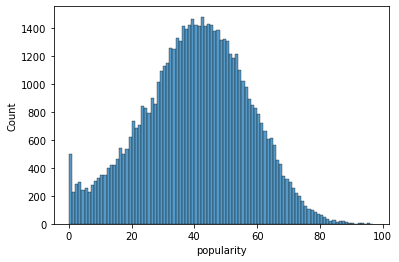

In [12]:
from seaborn import histplot
# looks like there are 4243 entries from the lyrics DF that don't have info
print(train_X.isnull().sum())

# what's the average popularity?
average_popularity = train_y.mean()
std_popularity = train_y.std()
print("Average popularity:", average_popularity)
print("Popularity standard deviation:", std_popularity)

# looks like the counts aren't very smooth
#histplot(train_y)

# nevermind, this is actually an effect of the plotting
histplot(train_y, bins=97, binwidth=1)

# n_words

-1.0       9314
 18.0       491
 184.0      283
 1.0        244
 227.0      237
           ... 
 1076.0       1
 1039.0       1
 955.0        1
 1484.0       1
 985.0        1
Name: n_words, Length: 1187, dtype: int64
38.48840455228688


<AxesSubplot:xlabel='n_words', ylabel='popularity'>

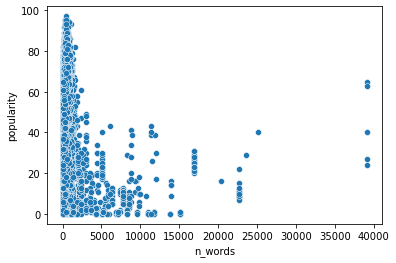

In [13]:
from seaborn import scatterplot
# looks like -1 means there are no words in the song
print(train_X["n_words"].value_counts())

# what's the average popularity of songs without words?
print(train[train["n_words"] == -1.0]["popularity"].mean())
# looks like it isn't much different from the overall mean

# this plot also shows that there's no much relation between n_words and popularity
scatterplot(data=train, x='n_words', y='popularity')

# energy

Average energy is: 0.5857870609535117


<AxesSubplot:xlabel='energy', ylabel='popularity'>

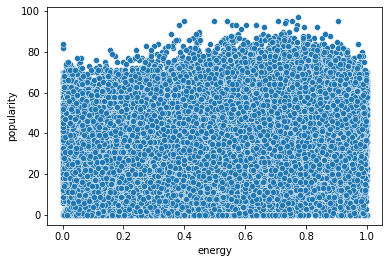

In [14]:
# what's the average energy?
print("Average energy is:", train["energy"].mean())

# this plot also shows that there's no much relation between energy and popularity,
# in fact, looks like energy is uniformly distributed
scatterplot(data=train, x='energy', y='popularity')

# danceability

Average danceability is: 0.586282925951968


<AxesSubplot:xlabel='danceability', ylabel='popularity'>

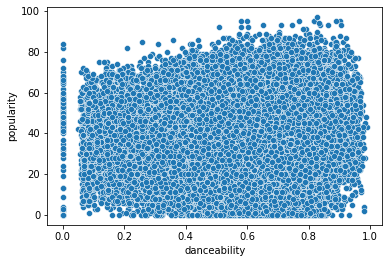

In [15]:
# what's the average danceability?
print("Average danceability is:", train["danceability"].mean())

# the picture looks similar to the one for energy, but there is a small upward trend
scatterplot(data=train, x='danceability', y='popularity')

# all numerical features

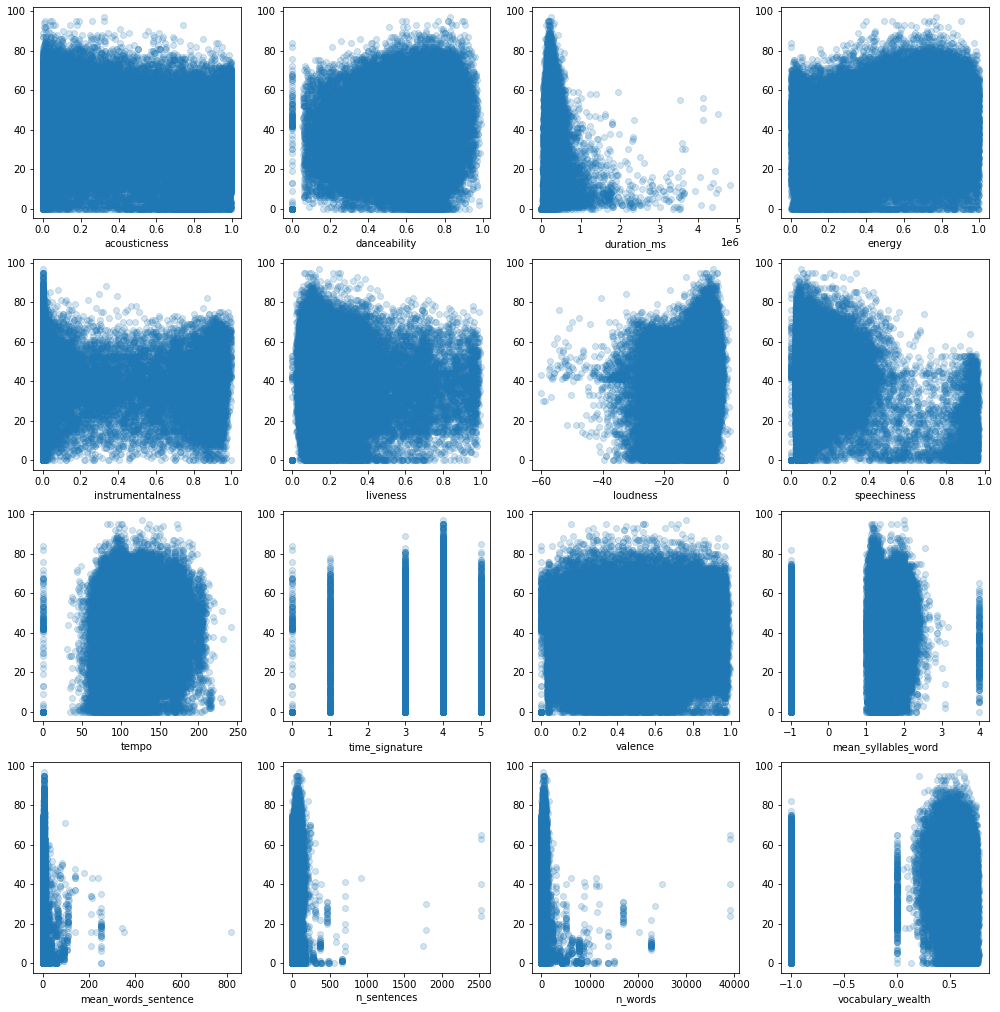

In [16]:
import matplotlib.pyplot as plt

# let's plot all numerical features against popularity
training_features = [f for f in train.columns.to_list() if f != 'popularity']
num_features = len(training_features)

#define grid of plots
ncols = 4
nrows = int(num_features / ncols) + (1 if num_features % ncols != 0 else 0)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,14))
fig.tight_layout(h_pad=2)

#add data to plots
for i, feature in enumerate(training_features):
    row = int(i / ncols)
    col = i % ncols
    axs[row][col].scatter(train[feature], train["popularity"], alpha=0.2)
    plt.setp(axs[row, col], xlabel=feature)


Basically what I gleaned from these scatter plots is that, there aren't too many features that can strongly indicate whether a song will be popular. Acousticness seems barely negatively correlated, danceability is slightly correlated, duration definitely has some negative correlation, energy has slight correlation, liveness has slight negative correlation, loudness seems to be correlated, and speechiness. I did not get much else from the other features, and also I noticed that some values for the features are essentially null values, like -1.0 for vocabulary_wealth.

In [17]:
train[training_features].corrwith(train["popularity"]).abs().sort_values(ascending=False)

speechiness            0.301737
loudness               0.236123
duration_ms            0.169594
acousticness           0.153489
energy                 0.152437
time_signature         0.117691
mean_words_sentence    0.097828
n_words                0.092076
danceability           0.091179
liveness               0.061826
tempo                  0.059532
mean_syllables_word    0.040976
instrumentalness       0.040798
n_sentences            0.040371
valence                0.035499
vocabulary_wealth      0.024428
dtype: float64

# Data Munging

In [18]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler

print(train.isna().sum())

def prepare_input(df, dv=None, polynomial=False, scale_features=True):
    # input na with 0
    df_imputed = df.fillna(0)
    
    # feature scaling
    df_scaled = df_imputed
    
    if scale_features:
        scaler = RobustScaler()
        df_scaled = scaler.fit_transform(df_imputed)
        df_scaled = pd.DataFrame(df_scaled, columns=training_features)
    
    df_polynomial = df_scaled
    if polynomial:
        polynomial_features = PolynomialFeatures(degree = 2, include_bias = False)
        df_polynomial = polynomial_features.fit_transform(df_scaled)
        df_polynomial = pd.DataFrame(df_polynomial)

    df_dict = df_polynomial.to_dict(orient='records')

    if dv is None:
        dv = DictVectorizer()
        df_vectorized = dv.fit_transform(df_dict)
        return df_vectorized, dv
    else:
        df_vectorized = dv.transform(df_dict)
    
    return df_vectorized

acousticness              0
danceability              0
duration_ms               0
energy                    0
instrumentalness          0
liveness                  0
loudness                  0
speechiness               0
tempo                     0
time_signature            0
valence                   0
mean_syllables_word    4243
mean_words_sentence    4243
n_sentences            4243
n_words                4243
vocabulary_wealth      4243
popularity                0
dtype: int64


# Training the Linear Regression Model (with regularization)

In [19]:
from sklearn.linear_model import Ridge

def train_ridge_regressor(train_X, train_y, polynomial=False, c=1):
    rr = Ridge(alpha=c)
    train_X_prepared, dv = prepare_input(train_X, None, polynomial)
    rr.fit(train_X_prepared, train_y)
    
    return rr, dv

# Checking validation performance across different C, polynomial parameters

In [20]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [21]:
polynomial_parameters = [False, True]
best_polynomial_parameter = polynomial_parameters[0]
best_polynomial_performance = float('inf')
for polynomial_parameter in polynomial_parameters:
    rr, dv = train_ridge_regressor(train_X, train_y, polynomial_parameter, 1)
    train_X_prepared = prepare_input(train_X, dv, polynomial_parameter)
    train_y_pred = rr.predict(train_X_prepared)
    val_X_prepared = prepare_input(val_X, dv, polynomial_parameter)
    val_y_pred = rr.predict(val_X_prepared)
    train_rmse = rmse(train_y, train_y_pred)
    val_rmse = rmse(val_y, val_y_pred)
    print("Polynomial =", polynomial_parameter, "RMSE for Linear Regression on Training Data:", train_rmse)
    print("Polynomial =", polynomial_parameter, "RMSE for Linear Regression on Validation Data:", val_rmse)
    
    if val_rmse < best_polynomial_performance:
        best_polynomial_performance = val_rmse
        best_polynomial_parameter = polynomial_parameter
# looks like the version with polynomial features is better

c_parameters = [1e-3, 0.1, 1, 1000, 1e6, 1e9]
best_c_parameter = polynomial_parameters[0]
best_c_performance = float('inf')
for c in c_parameters:
    rr, dv = train_ridge_regressor(train_X, train_y, best_polynomial_parameter, c)
    val_X_prepared = prepare_input(val_X, dv, best_polynomial_parameter)
    val_y_pred = rr.predict(val_X_prepared)
    train_X_prepared = prepare_input(train_X, dv, best_polynomial_parameter)
    train_y_pred = rr.predict(train_X_prepared)
    train_rmse = rmse(train_y, train_y_pred)
    val_rmse = rmse(val_y, val_y_pred)
    print("alpha =", c, "RMSE for Linear Regression on Training Data:", train_rmse)
    print("alpha =", c, "RMSE for Linear Regression on Validation Data:", val_rmse)
    
    if val_rmse < best_c_performance:
        best_c_performance = val_rmse
        best_c_parameter = c

Polynomial = False RMSE for Linear Regression on Training Data: 15.414827112357631
Polynomial = False RMSE for Linear Regression on Validation Data: 15.398349724989782
Polynomial = True RMSE for Linear Regression on Training Data: 14.660001628697277
Polynomial = True RMSE for Linear Regression on Validation Data: 14.872541519698741
alpha = 0.001 RMSE for Linear Regression on Training Data: 14.649352718667014
alpha = 0.001 RMSE for Linear Regression on Validation Data: 14.857186813109303
alpha = 0.1 RMSE for Linear Regression on Training Data: 14.643949714049812
alpha = 0.1 RMSE for Linear Regression on Validation Data: 14.832715071880493
alpha = 1 RMSE for Linear Regression on Training Data: 14.660001628697277
alpha = 1 RMSE for Linear Regression on Validation Data: 14.872541519698741
alpha = 1000 RMSE for Linear Regression on Training Data: 14.663494942604473
alpha = 1000 RMSE for Linear Regression on Validation Data: 14.849389301503262
alpha = 1000000.0 RMSE for Linear Regression on 

In [22]:
print("Use polynomial =", best_polynomial_parameter)
print("Use alpha =", best_c_parameter)

Use polynomial = True
Use alpha = 0.1


Looks like the default alpha of 1 is sufficient to keep both training and validation RMSE close, even though the absolute value is quite large (\~15.4), but better with polynomial features (\~14.7). I'm not sure if I can do better than this model. 

# Test Performance

In [23]:
train_val_X = pd.concat([train_X, val_X])
train_val_y = pd.concat([train_y, val_y])

In [24]:
rr, dv = train_ridge_regressor(train_val_X, train_val_y, True, 0.1)

In [25]:
test_X_prepared = prepare_input(test_X, dv, True, True)
test_y_pred = rr.predict(test_X_prepared)
test_rmse = rmse(test_y, test_y_pred)

print("RMSE for Linear Regression on Test Data:", test_rmse)

RMSE for Linear Regression on Test Data: 14.645876802300744


# Pickle The Models

In [26]:
import pickle
model_filename = "ridge_regressor_polynomial_alpha_1e-1.bin"
dict_vectorizer_filename = "spotify_dict_vectorizer.bin"
model_bin = open(model_filename, 'wb')
dv_bin = open(dict_vectorizer_filename, 'wb')

pickle.dump(rr, model_bin)
pickle.dump(dv, dv_bin)

model_bin.close()
dv_bin.close()